# textCNN实现商品评论二分类

In [19]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

2.0.0-alpha0
2.2.4-tf


In [14]:
import os
import csv
import time
import datetime
import random
import json
from collections import Counter
from math import sqrt
import gensim
import pandas as pd
import numpy as np



from tensorflow.keras.layers import Input,Conv2D,MaxPool2D,concatenate,Flatten,Dense,Dropout,Embedding,Reshape
from tensorflow.keras import Sequential,optimizers,losses
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from bs4 import BeautifulSoup
import logging
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import multiprocessing
import yaml
import jieba


# 参数配置

In [2]:
class Config(object):
    
    #数据集路径
    dataSource = "../data/goods_zh.txt"
    stopWordSource = "../data/stopword.txt"
    
    #分词后保留大于等于最低词频的词
    miniFreq=1
    
    
    #统一输入文本序列的定长，取了所有序列长度的均值。超出将被截断，不足则补0
    sequenceLength = 200  
    batchSize=64
    epochs=10
    
    numClasses = 2
    #训练集的比例
    rate = 0.8  
    
    
    #生成嵌入词向量的维度
    embeddingSize = 150
    
    #卷积核数
    numFilters = 30
    
    #卷积核大小
    filterSizes = [2,3,4,5]
    dropoutKeepProb = 0.5
    
    #L2正则系数
    l2RegLambda = 0.1
    
   

    
# 实例化配置参数对象
config = Config()

In [3]:
config.batchSize

64

# 预训练词向量

In [4]:
#中文语料
#设置输出日志
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

file = open("../data/goods_zh.txt") 
sentences=[]
for line in file:
    temp=line.replace('\n','').split(',,')
    sentences.append(jieba.lcut(temp[0]))
file.close()


model = word2vec.Word2Vec(sentences,size=config.embeddingSize,
                     min_count=config.miniFreq,
                     window=10,
                     workers=multiprocessing.cpu_count(),sg=1,
                     iter=20)
model.save('../data/word2VecModel')


Building prefix dict from the default dictionary ...
I0508 13:30:55.175876 140735550804864 __init__.py:111] Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/60/2w7_vlcs36d59_tzgd2g3hv40000gn/T/jieba.cache
I0508 13:30:55.178590 140735550804864 __init__.py:131] Loading model from cache /var/folders/60/2w7_vlcs36d59_tzgd2g3hv40000gn/T/jieba.cache
Loading model cost 3.559 seconds.
I0508 13:30:58.737360 140735550804864 __init__.py:163] Loading model cost 3.559 seconds.
Prefix dict has been built succesfully.
I0508 13:30:58.752737 140735550804864 __init__.py:164] Prefix dict has been built succesfully.
W0508 13:33:47.724422 140735550804864 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance


In [5]:
model = gensim.models.Word2Vec.load('../data/word2VecModel')
model.wv.vocab.keys()

dict_keys(['才', '用', '就', '发现', '相机', '打开', '迟钝', '，', '半天', '反应', '不', '过来', '有时候', '还会卡', '出去', '他们', '又', '给', '解决方案', '。', '还', '没', '穿', '二天', '起毛', '了', '坑', '呢', '！', '我', '怎样', '将', '双卡', '和', '内存卡', '一起', '装进去', '吗', '？', '如果', '不能', '说', '什么', '支持', 'SD', '?', '-', '诺基亚', '手机', '做工', '质量', '太', '差', '后壳', '垃圾', '没用', '几天', '掉', '漆', '为', '毛要', '金属', '材质', '为啥', '不用', '陶瓷', '呀', '我后', '壳', '贴膜', '完', '整体', '的', '感觉', '还是', '不错', '非常', '满意', '京东', '售后服务', '买', '之前', '联系', '客服', '由于', '公司', '新开', '增值税', '发票', '开票', '信息', '出来', '要', '再', '结果', '开', '电子', '换', '电脑', '帐', '裤子', '很', '好', '昨天', '刚买', '保修', '到', '9', '月份', '还有', '一次', '鉴定', '这', '是', '啥', '机子', '冬天', '比较', '保暖', '品质', '保证', '价格', '实惠', '收到', '后', '知道', '怎么', '吧', '从', '下单', '心情', '兴奋', '之后', '糟糕', '透', '东西', '都', '没有', '一部', '一个', '充电器', '连', '百元', '机', '标配', '耳机', '别的', '计较', '太过分', '啊', ' ', '在', '北京', '呆', '3', '天', '动弹', '真', '几把', '慢', '好大', '味道', '放', '三四天', '那个', '味', '去', '不了', '货来', '还行', '两个', '星期', '左右', '

In [6]:
model['不规则']

/Users/monstar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-2.6186418e-02,  2.4990086e-01, -1.3414274e-01, -3.7025166e-01,
       -1.5653297e-02,  2.2986029e-01,  6.5927296e-03, -5.5867261e-01,
        3.3230445e-01, -2.0446055e-01,  6.9828793e-02,  4.8141591e-02,
       -5.4865416e-02, -1.3763855e-01, -1.5709996e-01,  2.3588772e-01,
       -2.2220381e-01, -4.6031466e-03,  1.8163912e-01, -1.0699948e-01,
       -1.4773484e-01,  1.6440895e-01, -3.6679381e-03,  4.6431521e-01,
        1.7621307e-01,  1.4967148e-01, -2.2185639e-01, -2.4388555e-01,
       -4.1942999e-02,  7.0012487e-02, -3.5928899e-01,  9.0971380e-02,
       -3.0901214e-01,  1.2371730e-01, -2.2853243e-01, -1.0133176e-01,
        1.9128393e-01,  5.6734137e-02, -3.8970925e-02, -2.9379788e-01,
        6.4888515e-02,  1.2794431e-02, -1.0926029e-01,  2.7044535e-01,
       -3.2047698e-01, -2.3797762e-01, -8.8041969e-02, -9.2874371e-02,
       -7.9032250e-02, -5.4278129e-01,  1.6839357e-02,  3.8996288e-01,
       -3.6037439e-01,  2.3512635e-01, -3.3385947e-01,  4.1176897e-01,
      

# 数据预处理

In [7]:
# 数据预处理的类，生成训练集和测试集
class Dataset(object):
    def __init__(self, config):
        self.dataSource = config.dataSource
        self.stopWordSource = config.stopWordSource  
        
        # 每条输入的序列处理为定长
        self.sequenceLength = config.sequenceLength  
        self.embeddingSize = config.embeddingSize
        
        self.rate = config.rate
        self.miniFreq=config.miniFreq
        
        self.stopWordDict = {}
        
        self.trainReviews = []
        self.trainLabels = []
        
        self.evalReviews = []
        self.evalLabels = []
        
        self.wordEmbedding =None
        self.n_symbols=0
        
        self.wordToIndex = {}
        self.indexToWord = {}
        
        
        
    def readData(self, filePath):
        file = open(filePath) 
        text=[]
        label=[]
        for line in file:
            temp=line.replace('\n','').split(',,')
            text.append(temp[0])
            label.append(temp[1])
        file.close()
        
        print('data:',len(text),len(label))
        texts = [jieba.lcut(document.replace('\n', '')) for document in text]

        return texts, label

    
    def readStopWord(self, stopWordPath):
        """
        读取停用词
        """
        
        with open(stopWordPath, "r") as f:
            stopWords = f.read()
            stopWordList = stopWords.splitlines()
            # 将停用词用列表的形式生成，之后查找停用词时会比较快
            self.stopWordDict = dict(zip(stopWordList, list(range(len(stopWordList)))))
    
    
    def getWordEmbedding(self, words):
        """
        按照我们的数据集中的单词取出预训练好的word2vec中的词向量
        """
        
        #中文
        model = gensim.models.Word2Vec.load('../data/word2VecModel')
        
        vocab = []
        wordEmbedding = []
        
        # 添加 "pad" 和 "UNK", 
        vocab.append("pad")
        wordEmbedding.append(np.zeros(self.embeddingSize))
        
        vocab.append("UNK")
        wordEmbedding.append(np.random.randn(self.embeddingSize))
        
        for word in words:
            try:
                vector =model[word]
                vocab.append(word)
                wordEmbedding.append(vector)
                
            except:
                print(word + "不存在于词向量中")
                
        return vocab, np.array(wordEmbedding)
    
    
    
    def genVocabulary(self, reviews):
        """
        生成词向量和词汇-索引映射字典，可以用全数据集
        """
        
        allWords = [word for review in reviews for word in review]
        
        #去掉停用词
        subWords = [word for word in allWords if word not in self.stopWordDict]
        
        #统计词频，排序
        wordCount = Counter(subWords)  
        sortWordCount = sorted(wordCount.items(), key=lambda x: x[1], reverse=True)
        
        #去除低频词
        words = [item[0] for item in sortWordCount if item[1] >= self.miniFreq ]
        
        
        #获取词列表和顺序对应的预训练权重矩阵
        vocab, wordEmbedding = self.getWordEmbedding(words)
        
        self.wordEmbedding = wordEmbedding
        
        self.wordToIndex = dict(zip(vocab, list(range(len(vocab)))))
        self.indexToWord = dict(zip(list(range(len(vocab))), vocab))
        self.n_symbols = len(self.wordToIndex) + 1
        
        # 将词汇-索引映射表保存为json数据，之后做inference时直接加载来处理数据
        with open("../data/wordJson/wordToIndex.json", "w", encoding="utf-8") as f:
            json.dump(self.wordToIndex, f)
        
        with open("../data/wordJson/indexToWord.json", "w", encoding="utf-8") as f:
            json.dump(self.indexToWord, f)
            
            
            
            
    
    def reviewProcess(self, review, sequenceLength, wordToIndex):
        """
        将数据集中的每条评论里面的词，根据词表，映射为index表示
        每条评论 用index组成的定长数组来表示
        
        """
        
        reviewVec = np.zeros((sequenceLength))
        sequenceLen = sequenceLength
        
        # 判断当前的序列是否小于定义的固定序列长度
        if len(review) < sequenceLength:
            sequenceLen = len(review)
            
        for i in range(sequenceLen):
            if review[i] in wordToIndex:
                reviewVec[i] = wordToIndex[review[i]]
            else:
                reviewVec[i] = wordToIndex["UNK"]

        return reviewVec

    
    
    
    def genTrainEvalData(self, x, y, rate):
        """
        生成训练集和验证集
        """
        
        reviews = []
        labels = []
        
        # 遍历所有的文本，将文本中的词转换成index表示
        for i in range(len(x)):
            
            reviewVec = self.reviewProcess(x[i], self.sequenceLength, self.wordToIndex)
            reviews.append(reviewVec)
            
            labels.append([y[i]])
            
        trainIndex = int(len(x) * rate)
        
       
        #trainReviews = sequence.pad_sequences(reviews[:trainIndex], maxlen=self.sequenceLength)
        trainReviews = np.asarray(reviews[:trainIndex], dtype="int64")
        trainLabels = np.array(labels[:trainIndex], dtype="float32")
        
        #evalReviews = sequence.pad_sequences(reviews[trainIndex:], maxlen=self.sequenceLength)
        evalReviews = np.asarray(reviews[trainIndex:], dtype="int64")
        evalLabels = np.array(labels[trainIndex:], dtype="float32")

        return trainReviews, trainLabels, evalReviews, evalLabels
        
        
        
        
 
            
    def dataGen(self):
        """
        初始化训练集和验证集
        """
        
        #读取停用词
        self.readStopWord(self.stopWordSource)
        
        #读取数据集
        reviews, labels = self.readData(self.dataSource)
        
        #分词、去停用词
        #生成 词汇-索引 映射表和预训练权重矩阵，并保存
        self.genVocabulary(reviews)
        
        
        #初始化训练集和测试集
        trainReviews, trainLabels, evalReviews, evalLabels = self.genTrainEvalData(reviews, labels, self.rate)
        self.trainReviews = trainReviews
        self.trainLabels = trainLabels
        
        self.evalReviews = evalReviews
        self.evalLabels = evalLabels
        
        
data = Dataset(config)
data.dataGen()

data: 101058 101058


/Users/monstar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [8]:
print("train data shape: {}".format(data.trainReviews.shape))
print("train label shape: {}".format(data.trainLabels.shape))
print("eval data shape: {}".format(data.evalReviews.shape))

train data shape: (80846, 200)
train label shape: (80846, 1)
eval data shape: (20212, 200)


# 定义网络结构

In [10]:

def convolution(config):
    sequence_length=config.sequenceLength
    embedding_dimension=config.embeddingSize
    
    inn = Input(shape=(sequence_length, embedding_dimension, 1))
    cnns = []
    filter_sizes=config.filterSizes
    for size in filter_sizes:
        conv = Conv2D(filters=config.numFilters, kernel_size=(size, embedding_dimension),
                            strides=1, padding='valid', activation='relu')(inn)
        pool = MaxPool2D(pool_size=(sequence_length-size+1, 1), padding='valid')(conv)
        cnns.append(pool)
    outt =concatenate(cnns)

    model = Model(inputs=inn, outputs=outt)
    return model



def cnn_mulfilter(n_symbols,embedding_weights,config):

    model =Sequential([
        
        Embedding(input_dim=n_symbols, output_dim=config.embeddingSize,
                        weights=[embedding_weights],
                        input_length=config.sequenceLength),
        
        
        Reshape((config.sequenceLength, config.embeddingSize, 1)),
        
        convolution(config),
        Flatten(),
        Dense(10, activation='relu',kernel_regularizer=regularizers.l2(config.l2RegLambda)),
        Dropout(config.dropoutKeepProb),
        Dense(1, activation='sigmoid')])
        
    model.compile(optimizer=optimizers.Adam(),
                 loss=losses.BinaryCrossentropy(),
                 metrics=['accuracy'])
    return model
    
wordEmbedding = data.wordEmbedding
n_symbols=data.n_symbols
model = cnn_mulfilter(n_symbols,wordEmbedding,config)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 150)          3756450   
_________________________________________________________________
reshape_1 (Reshape)          (None, 200, 150, 1)       0         
_________________________________________________________________
model_1 (Model)              (None, 1, 1, 120)         63120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1210      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

# 训练模型

In [15]:
x_train = data.trainReviews
y_train = data.trainLabels
x_eval = data.evalReviews
y_eval = data.evalLabels

wordEmbedding = data.wordEmbedding
n_symbols=data.n_symbols


reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, mode='auto')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('./model/best_model/model_{epoch:02d}-{val_accuracy:.2f}.hdf5', save_best_only=True, save_weights_only=True)
history = model.fit(x_train, y_train, batch_size=config.batchSize, epochs=config.epochs, validation_split=0.3,shuffle=True, callbacks=[reduce_lr,early_stopping,model_checkpoint])
#验证

scores = model.evaluate(x_eval, y_eval)

#保存模型
yaml_string = model.to_yaml()
with open('./model/textCNN.yml', 'w') as outfile:
    outfile.write( yaml.dump(yaml_string, default_flow_style=True) )
model.save_weights('./model/textCNN.h5')

print('test_loss: %f, accuracy: %f' % (scores[0], scores[1]))

Train on 56592 samples, validate on 24254 samples
Epoch 1/10
56592/56592 [==============================] - 1093s 19ms/sample - loss: 0.5400 - accuracy: 0.8694 - val_loss: 0.2311 - val_accuracy: 0.9252
Epoch 2/10
56592/56592 [==============================] - 971s 17ms/sample - loss: 0.2737 - accuracy: 0.9210 - val_loss: 0.2217 - val_accuracy: 0.9293
Epoch 3/10
56592/56592 [==============================] - 1235s 22ms/sample - loss: 0.2395 - accuracy: 0.9290 - val_loss: 0.2072 - val_accuracy: 0.9299
Epoch 4/10
56592/56592 [==============================] - 988s 17ms/sample - loss: 0.2181 - accuracy: 0.9333 - val_loss: 0.2175 - val_accuracy: 0.9229
Epoch 5/10
56592/56592 [==============================] - 956s 17ms/sample - loss: 0.2033 - accuracy: 0.9377 - val_loss: 0.2295 - val_accuracy: 0.9290
Epoch 6/10
56592/56592 [==============================] - 980s 17ms/sample - loss: 0.1908 - accuracy: 0.9420 - val_loss: 0.2375 - val_accuracy: 0.9178
Epoch 7/10
56592/56592 [==================

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

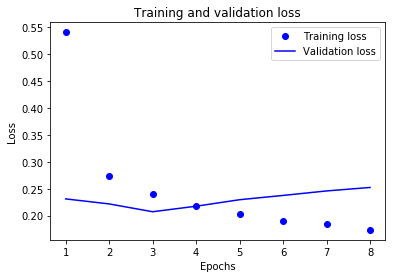

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

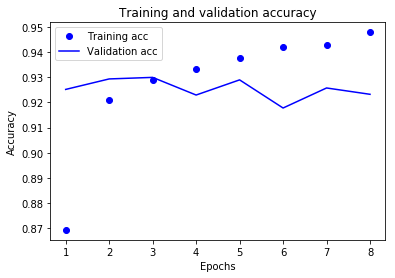

In [18]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()